In [6]:
import gseapy as gp
import pandas as pd
import numpy as np
import scipy.stats as stats
import glob
from biomart import BiomartServer
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import gseapy as gp
import os
from collections import defaultdict

from sklearn import decomposition
from sklearn import preprocessing

from scripts import aesthetics

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

NameError: name 'paper_rcParams' is not defined

# Analyze SV impact on RNA

In `pgsvs-sv-impact-on-rna-generate.ipynb`, we have generate a huge dataset that fully details the impact of somatic SVs on tumor RNA expression. 

Here, we explore that dataset in further detail. It was getting cumbersome needing to work around generating the data.

# Import our data

We have a ton of data to import (the drawback of having multiple notebooks). I've short-cutted what data needs to be imported by exporting already formatted in data in `sv-impact-on-rna-generate`

In [3]:
labels = ['gmkf_neuroblastoma_normalized_counts', 'gmkf_neuroblastoma_tpms', 'gmkf_neuroblastoma_normalized_tpms',
          'stjude_neuroblastoma_normalized_counts', 'stjude_neuroblastoma_tpms', 'stjude_neuroblastoma_normalized_tpms',
          'stjude_ewing_normalized_counts', 'stjude_ewing_tpms', 'stjude_ewing_normalized_tpms']
paths = [f'data/{l}.csv' for l in labels]

rna_dict = {}
dosage_dict = {}
for p, l in zip(paths, labels):
    data = pd.read_csv(p, index_col = 0)
    rna_dict[l] = data
    
    dosages = pd.read_csv(f'data/{l}-dosages-for-sv-rna-analysis.csv').iloc[:, 3:].set_index("ID")
    dosage_dict[l] = dosages

In [4]:
analysis_svs = pd.read_csv('data/svs-for-sv-rna-analysis.csv')

# and our actual results
sv_rna_results = pd.read_csv('data/sv-expression-results/sv-gene-rna-results-all-cohorts-all-analyses.csv')

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (34,35,37,39,41,45,47,72,73,87,88,106,107,121,122,136,137,155,156,170,171,185,186,204,205,219,220,234,235,253,254,268,269,283,284,302,303,366,367,381,382,400,401,415,416,430,431,449,450,464,465,479,480,498,499,513,514,528,529,547,548,562,563,577,578,596,597,645,646,647,648,649,650,690,691,692,693,694,695,713,714,728,729,743,744,758,759,773,774,788,789,803,804,818,819,833,834,848,849,863,864,878,879,893,894,908,909,923,924,931,937,943) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
sv_rna_results

,name,sv_effect,genic_relationship,gene,sv_coding_counts,sv_noncoding_counts,#chrom,start,end,svtype,...,cohort,cohort_af,average_cn,mean_exp,num_rna_genotyped,num_greater_0_dosage,mean_greater_0_dosage_rank,mean_greater_0_exp,mean_leq_0_exp,mwu_p
0,PedSV.2.5.2_CNV_chr1_6,noncoding,PREDICTED_NEAREST_TSS,OR4F29,0.0,1.0,chr1,257666,262901,CNV,...,gmkf_neuroblastoma_normalized_counts,NaN,0.224638,3987.007604,89,15,0.479924,3453.786590,4095.092944,0.775592
1,PedSV.2.5.2_CNV_chr1_7,noncoding,PREDICTED_NEAREST_TSS,OR4F29,0.0,1.0,chr1,262333,288667,CNV,...,gmkf_neuroblastoma_normalized_counts,NaN,0.862319,3987.007604,89,62,0.499175,4086.867409,3757.699902,0.971512
2,PedSV.2.5.2_CNV_chr1_8,noncoding,PREDICTED_NEAREST_TSS,OR4F29,0.0,1.0,chr1,431000,436001,CNV,...,gmkf_neuroblastoma_normalized_counts,NaN,0.086957,3987.007604,89,7,0.426136,2912.595149,4078.725740,0.492645
3,PedSV.2.5.2_CNV_chr1_9,noncoding,PREDICTED_NEAREST_TSS,OR4F16,0.0,1.0,chr1,585988,596501,CNV,...,gmkf_neuroblastoma_normalized_counts,NaN,-0.246377,3987.007604,89,6,0.504735,3810.970275,3999.733194,0.973884
4,PedSV.2.5.2_DEL_chr1_14,noncoding,PREDICTED_NEAREST_TSS,OR4F16,0.0,1.0,chr1,600354,600737,DEL,...,gmkf_neuroblastoma_normalized_counts,0.003650,NaN,3987.007604,89,1,0.761364,5830.189604,3966.062354,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187744,PedSV.2.5.2_INS_chrX_2887,noncoding,PREDICTED_INTRONIC,TMLHE,0.0,1.0,chrX,155560527,155560528,INS,...,stjude_ewing_normalized_tpms,0.354396,NaN,3.359001,18,12,0.465686,3.269401,3.538201,0.553221
187745,PedSV.2.5.2_DEL_chrX_9210,noncoding,PREDICTED_INTRONIC,TMLHE,0.0,1.0,chrX,155560600,155573801,DEL,...,stjude_ewing_normalized_tpms,0.758333,NaN,3.359001,18,17,0.519031,3.399584,2.669087,0.444444
187746,PedSV.2.5.2_DEL_chrX_9226,noncoding,PREDICTED_INTRONIC,SPRY3,0.0,1.0,chrX,155671554,155671610,DEL,...,stjude_ewing_normalized_tpms,0.005464,NaN,7.439992,18,1,0.235294,5.586444,7.549024,NaN
187747,PedSV.2.5.2_DEL_chrX_9230,noncoding,PREDICTED_INTRONIC,SPRY3,0.0,1.0,chrX,155688798,155692078,DEL,...,stjude_ewing_normalized_tpms,0.442623,NaN,7.439992,18,16,0.492647,7.388609,7.851061,0.836601


# Diving in

This data is super hard to wrap my head around. We'll start by answering some very straightforward questions.

## Do coding SVs affect expression? What about noncoding SVs?

To begin, I want to answer this question for SVs that are present in only one sample and "affect" only one gene. Much easier to think about.

In [16]:
# old_sv_rna_results = pd.read_csv('data/sv-expression-results/sv-gene-rna-results.csv')
# old_sv_rna_results['sv_effect'] = old_sv_rna_results['sv_effect'].replace({'non-coding': 'noncoding'})

In [17]:
# old = old_sv_rna_results[['name', 'gene', 'genic_relationship', 'sv_coding_counts', 'sv_non-coding_counts', 'mean_exp', 'num_greater_0_dosage', 'mean_greater_0_dosage_rank', 'mean_greater_0_exp', 'mean_leq_0_exp', 'sv_effect']]
# new = sv_rna_results[['name', 'gene', 'genic_relationship', 'mean_exp', 'num_greater_0_dosage', 'mean_greater_0_dosage_rank', 'mean_greater_0_exp', 'mean_leq_0_exp', 'cohort', 'sv_effect']]
# new = new[new['cohort'] == 'gmkf_neuroblastoma']

# merged = old.merge(new, on = ['name', 'gene', 'genic_relationship', 'sv_effect'], suffixes = ['_old', '_new'])
# merged_analysis = merged[(merged['sv_coding_counts'] + merged['sv_non-coding_counts'] == 1) &
#                          (merged['num_greater_0_dosage_old'] == 1)]

# merged_analysis_coding = merged_analysis.query('sv_effect == "coding"')

In [18]:
# sns.scatterplot(x = 'mean_greater_0_dosage_rank_old', y = 'mean_greater_0_dosage_rank_new', data = merged_analysis_coding)
# plt.plot([0, 1], [0, 1], color = 'black')

In [19]:
# plt.hist(merged_analysis_coding['mean_greater_0_dosage_rank_old'], bins = np.arange(0, 1.1, 0.05), alpha = 0.5)
# plt.hist(merged_analysis_coding['mean_greater_0_dosage_rank_new'], bins = np.arange(0, 1.1, 0.05), alpha = 0.5)

In [21]:
single_gene_sample_svs = sv_rna_results[((sv_rna_results['sv_coding_counts'] + sv_rna_results['sv_noncoding_counts']) == 1) &
                                        (sv_rna_results['num_greater_0_dosage'] == 1)]


print(single_gene_sample_svs[['cohort', 'sv_effect']].value_counts())

cohort                                  sv_effect
stjude_neuroblastoma_tpms               noncoding    8415
stjude_neuroblastoma_normalized_tpms    noncoding    8415
stjude_neuroblastoma_normalized_counts  noncoding    8415
gmkf_neuroblastoma_normalized_counts    noncoding    7943
gmkf_neuroblastoma_normalized_tpms      noncoding    7943
gmkf_neuroblastoma_tpms                 noncoding    7943
stjude_ewing_tpms                       noncoding    3851
stjude_ewing_normalized_tpms            noncoding    3851
stjude_ewing_normalized_counts          noncoding    3851
gmkf_neuroblastoma_tpms                 coding        192
gmkf_neuroblastoma_normalized_tpms      coding        192
gmkf_neuroblastoma_normalized_counts    coding        192
stjude_neuroblastoma_normalized_counts  coding        155
stjude_neuroblastoma_normalized_tpms    coding        155
stjude_neuroblastoma_tpms               coding        155
stjude_ewing_normalized_tpms            coding         54
stjude_ewing_tpms     

gmkf_neuroblastoma_normalized_counts 192 coding p = 0.10878077637792627 mean = 0.47764235366933555
gmkf_neuroblastoma_normalized_counts 7943 noncoding p = 0.9999999994752508 mean = 0.5061515659788611
gmkf_neuroblastoma_tpms 192 coding p = 0.01667064065251933 mean = 0.44604589871651196
gmkf_neuroblastoma_tpms 7943 noncoding p = 0.9998784992211214 mean = 0.5028278065455705
gmkf_neuroblastoma_normalized_tpms 192 coding p = 0.07843459195857672 mean = 0.4615295237029375
gmkf_neuroblastoma_normalized_tpms 7943 noncoding p = 0.9494724897947902 mean = 0.5035343318716765
stjude_neuroblastoma_normalized_counts 155 coding p = 0.06943828467727331 mean = 0.49775964082594315
stjude_neuroblastoma_normalized_counts 8415 noncoding p = 0.00010193262292701455 mean = 0.476873900387748
stjude_neuroblastoma_tpms 155 coding p = 0.39811053714708144 mean = 0.5117063272693823
stjude_neuroblastoma_tpms 8415 noncoding p = 0.0004672254227926498 mean = 0.4781386548333724
stjude_neuroblastoma_normalized_tpms 155 cod

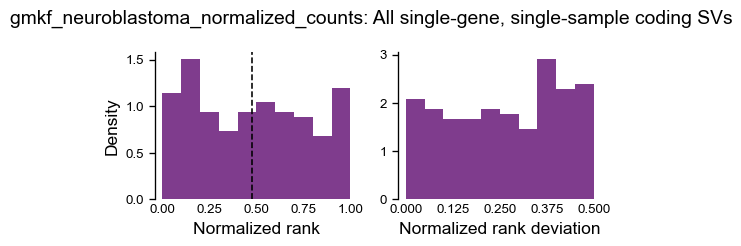

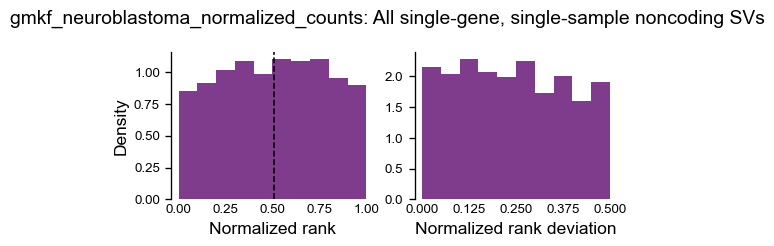

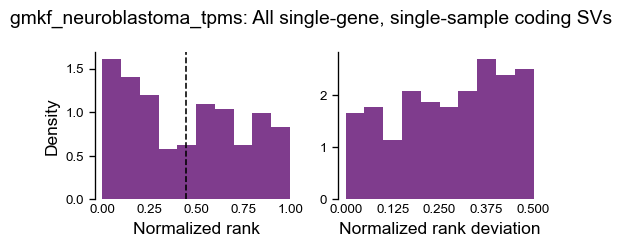

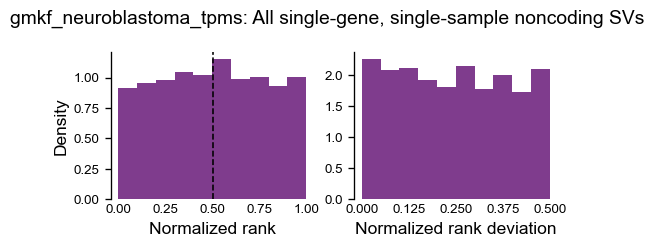

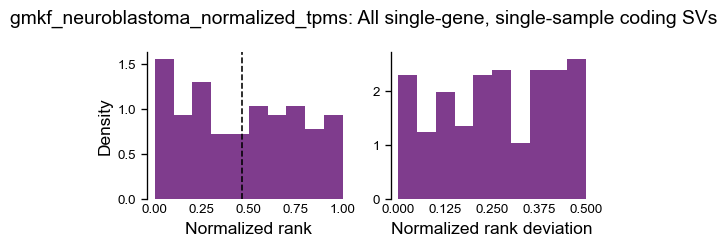

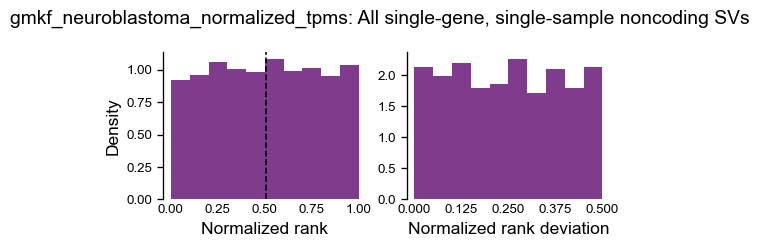

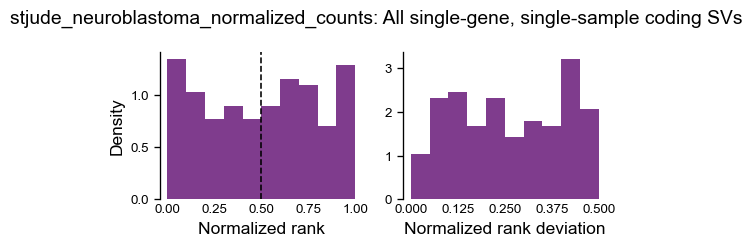

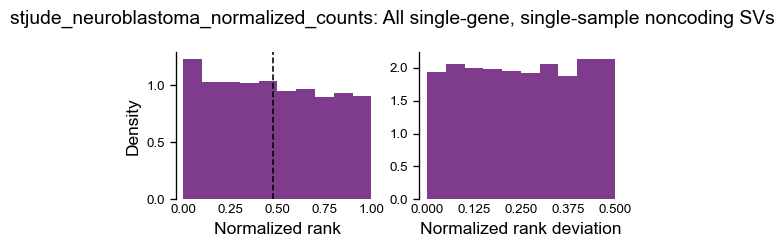

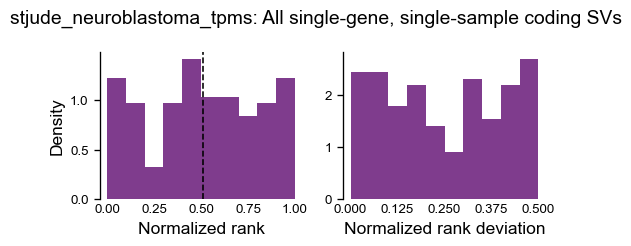

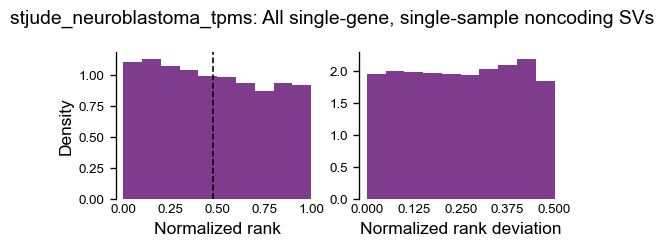

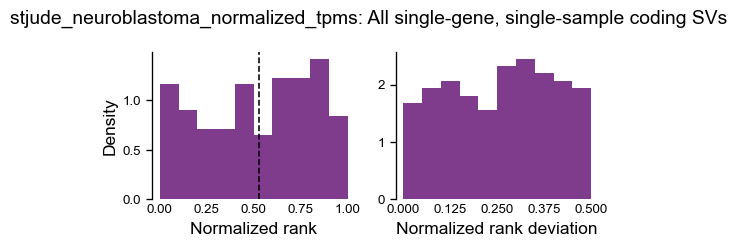

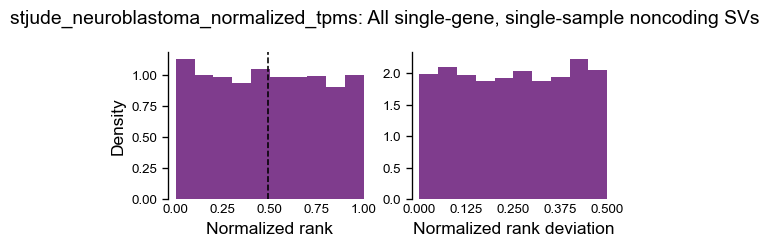

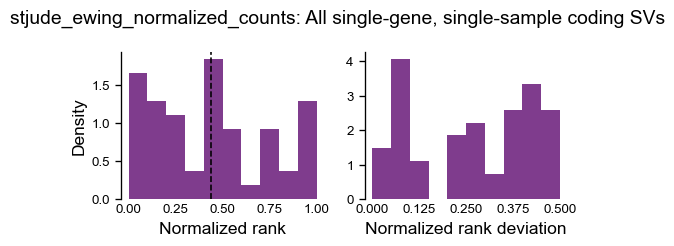

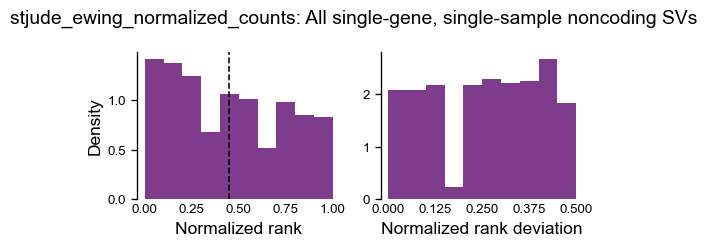

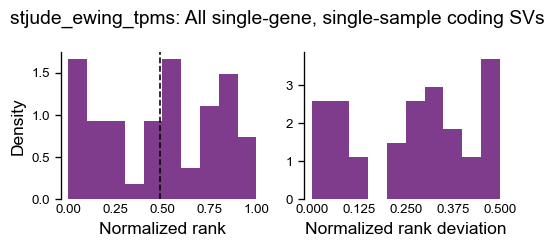

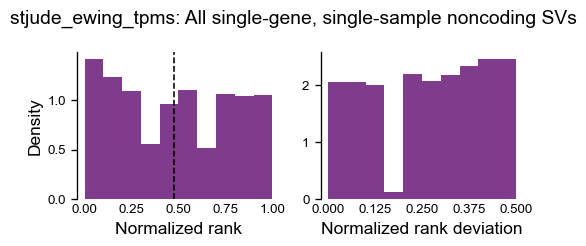

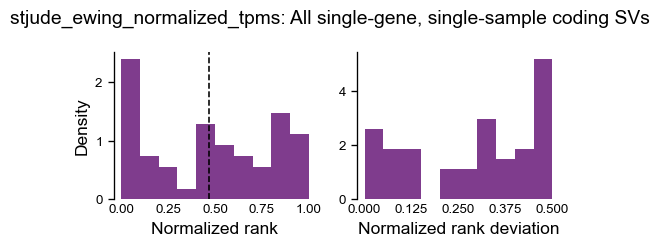

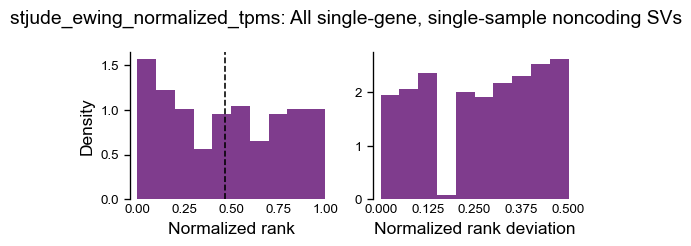

In [22]:
for cohort in rna_dict.keys():
    for sv_effect in ['coding', 'noncoding']:

        ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
        ss_sg_svs = ss_sg_svs[ss_sg_svs['cohort'] == cohort]
        rank_deviation = np.abs(0.5 - ss_sg_svs['mean_greater_0_dosage_rank'])

        fig, axes = plt.subplots(1, 2, figsize = (6, 2))
        axes[0].hist(ss_sg_svs['mean_greater_0_dosage_rank'], 
                     bins = np.arange(0, 1.1, 0.1), density = True)
        axes[0].axvline(x = ss_sg_svs['mean_greater_0_dosage_rank'].mean(), linestyle = 'dashed', color = 'black')
        axes[1].hist(rank_deviation, bins = np.arange(0, 0.55, 0.05),
                     density = True)

        for ax in axes:
            sns.despine(ax = ax, bottom = True)
            ax.tick_params(axis = 'x', length = 0)

        axes[0].set_xlim([-0.04, 1.04])
        axes[1].set_xlim([-0.02, 0.52])
        axes[1].set_xticks([0, 0.125, 0.25, 0.375, 0.5])

        axes[0].set_xlabel('Normalized rank')
        axes[1].set_xlabel('Normalized rank deviation')
        axes[0].set_ylabel('Density')

        # calculate a p value
        num_genes = len(ss_sg_svs)
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p = 1 - ref_dist.cdf(rank_deviation.mean())
        print(cohort, num_genes, sv_effect, 'p =', p, 'mean =', ss_sg_svs['mean_greater_0_dosage_rank'].mean())

        fig.suptitle(f'{cohort}: All single-gene, single-sample {sv_effect} SVs', y = 1.1)

        # fig.savefig(f'images/single-sample-single-gene-{sv_effect}-effect-on-expression.png', bbox_inches = 'tight')

So the coding SVs do have more of an effect than the noncoding SVs.

In [24]:
genic_rel_cols = {'coding': ['PREDICTED_LOF', 'PREDICTED_COPY_GAIN', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_PARTIAL_EXON_DUP'],
                  'noncoding': ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_UTR', 'PREDICTED_PROMOTER']}

## Examine impact of coding SVs by sv-type

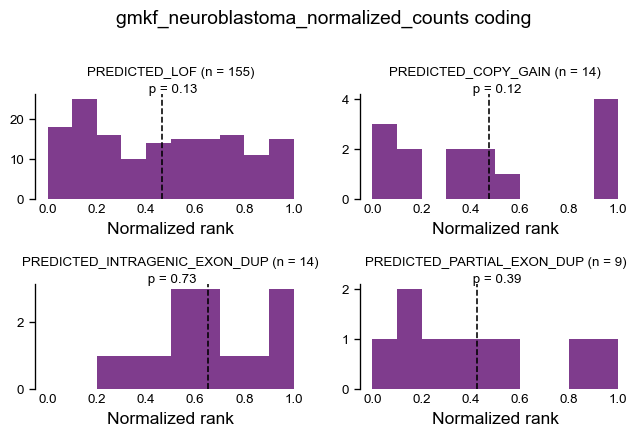

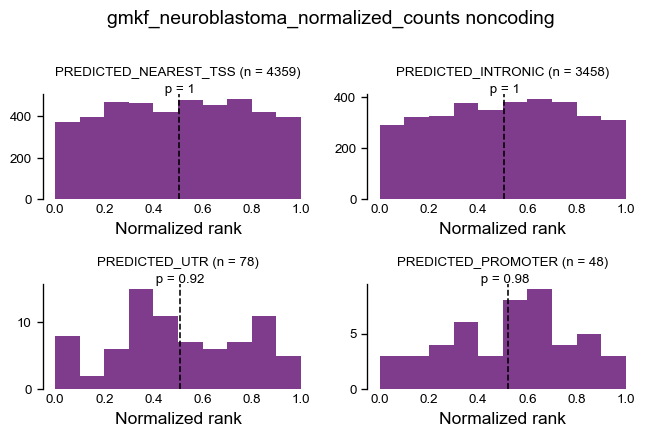

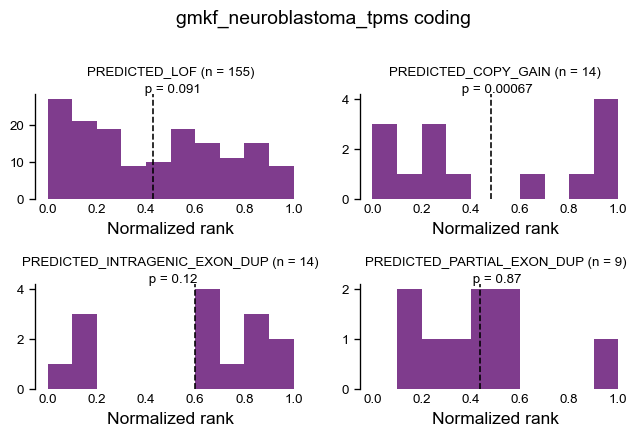

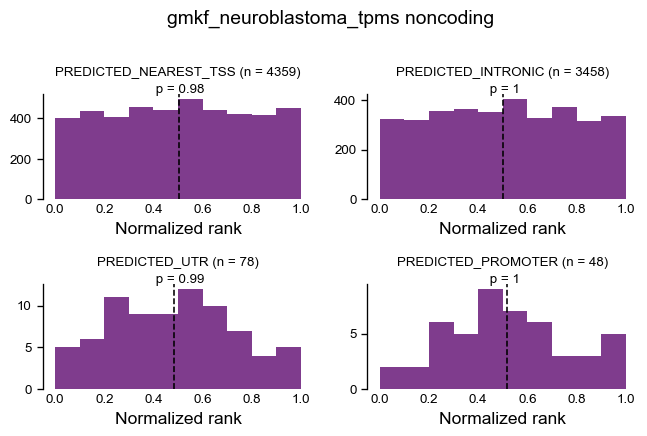

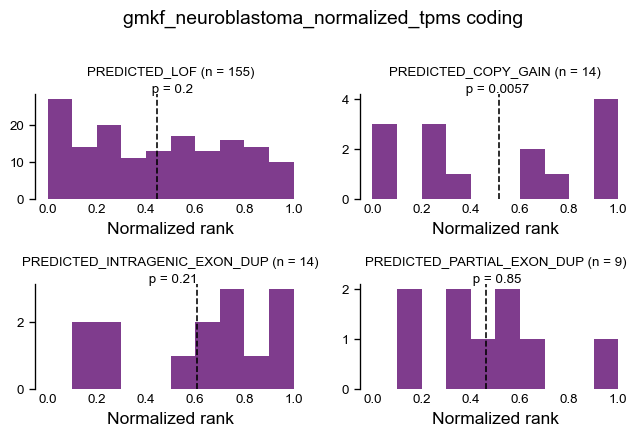

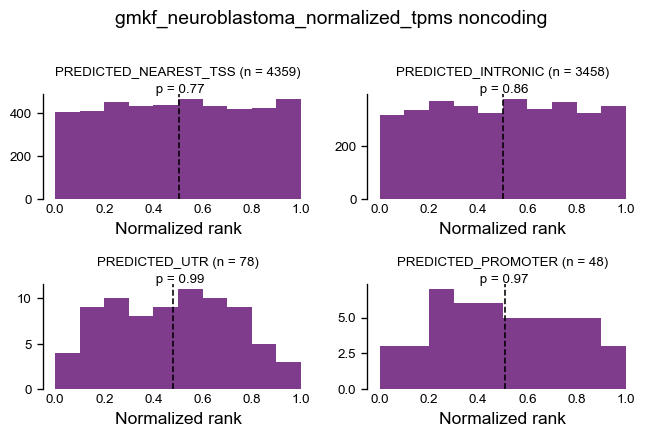

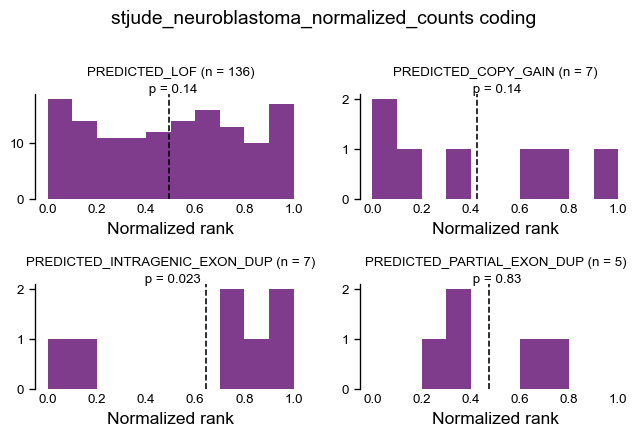

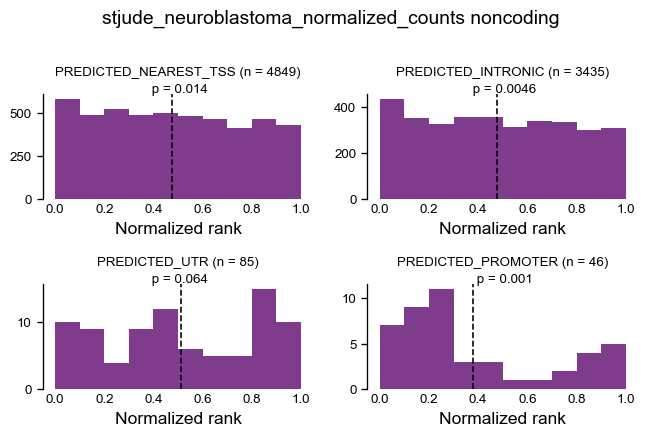

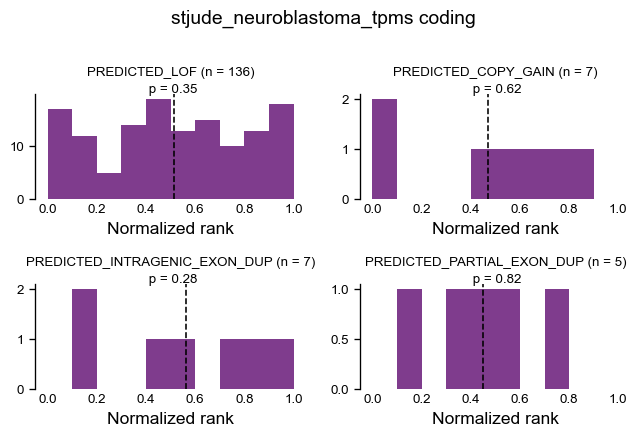

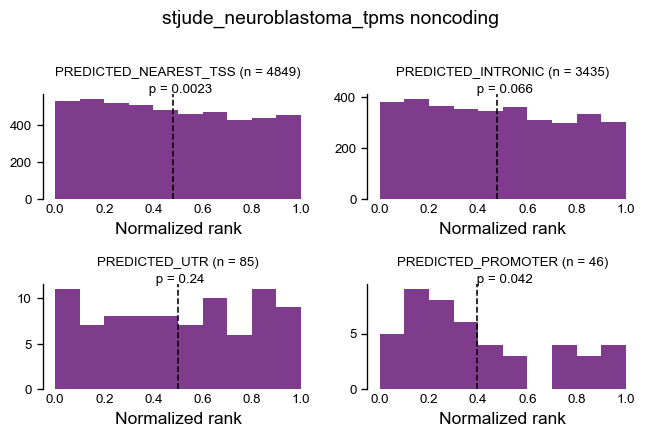

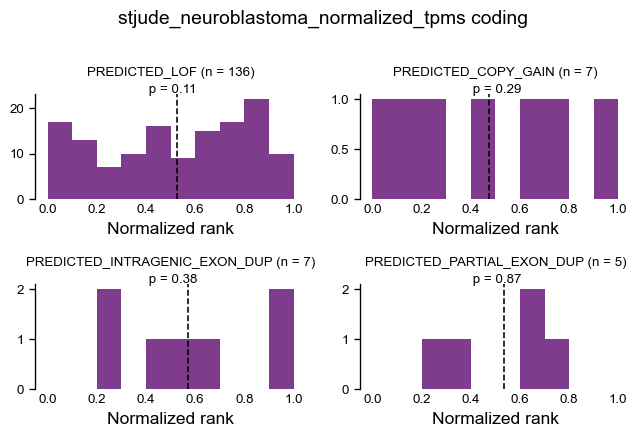

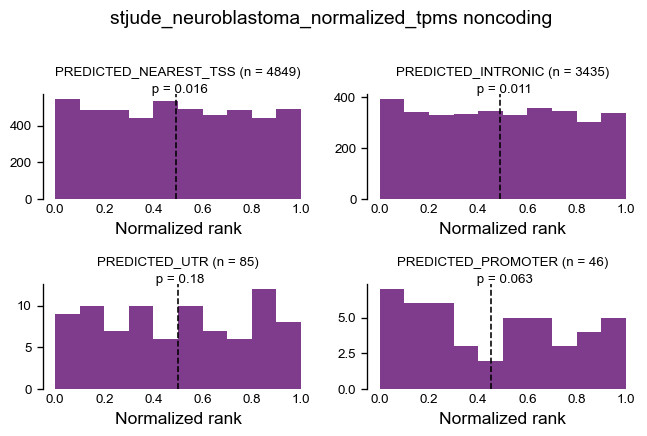

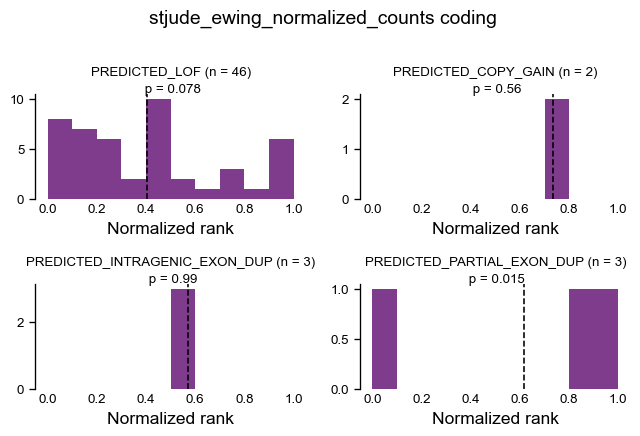

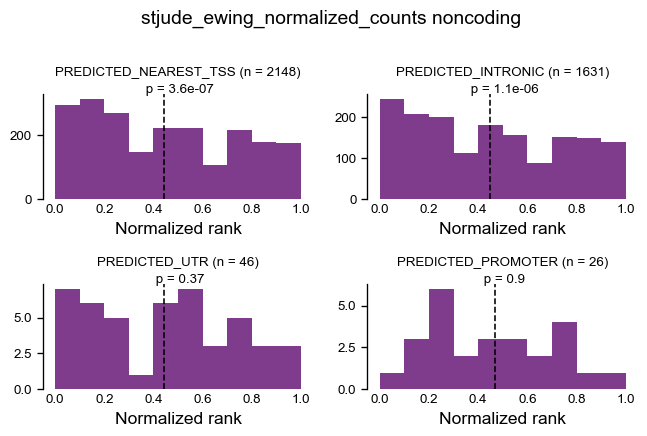

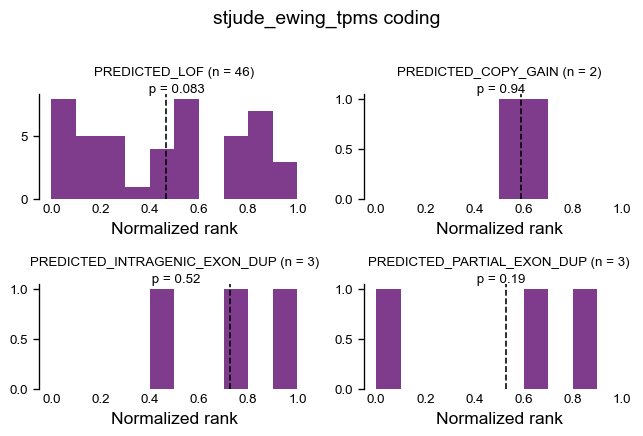

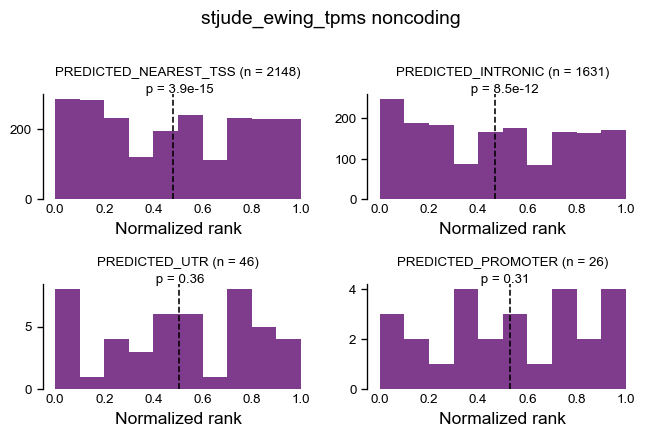

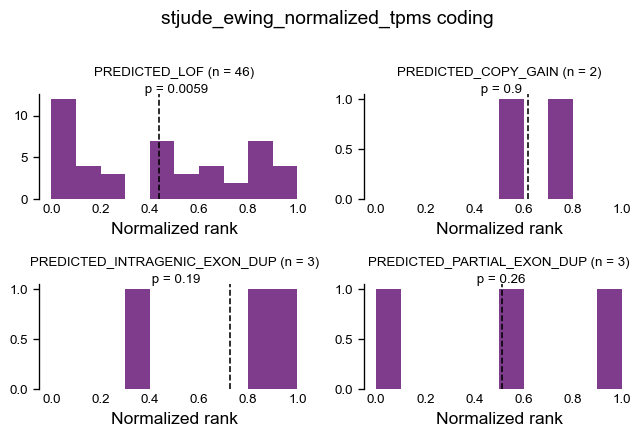

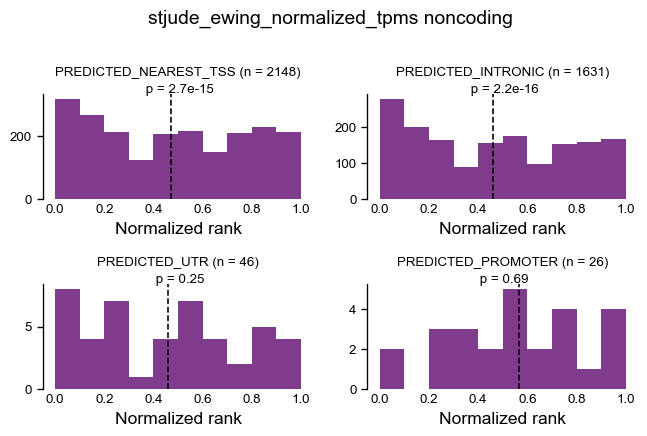

In [25]:
for cohort in rna_dict.keys():
    for sv_effect in ['coding', 'noncoding']:

        fig, axes = plt.subplots(2, 2, figsize = (8, 4), gridspec_kw = {'hspace': 0.8, 'wspace': 0.2})
        
        fig.suptitle(f'{cohort} {sv_effect}', y = 1.1)

        gr_cols = genic_rel_cols[sv_effect]
        ss_sg_svs = single_gene_sample_svs.query(f'sv_effect == "{sv_effect}"')
        ss_sg_svs = ss_sg_svs[ss_sg_svs['cohort'] == cohort]

        for i, svtype in enumerate(gr_cols):

            ax = axes.flat[i]
            sv_subset = ss_sg_svs[ss_sg_svs['genic_relationship'] == svtype]
            num_genes = len(sv_subset)

            ax.hist(sv_subset['mean_greater_0_dosage_rank'],
                    bins = np.arange(0, 1.1, 0.1), 
                    label = svtype)

            sns.despine(ax = ax, bottom = True)
            ax.tick_params(axis = 'x', length = 0)
            ax.set_title(svtype + f' (n = {num_genes})', fontsize = 10, y = 1.1)

            num_genes = len(sv_subset)
            rank_deviation = np.abs(0.5 - sv_subset['mean_greater_0_dosage_rank'])
            ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
            p = 1 - ref_dist.cdf(rank_deviation.mean())
            ax.text(s = " p = {:.2g}".format(p), x = 0.5, y = 1.1, fontsize = 10,
                    ha = 'center', va = 'top', transform = ax.transAxes)
            ax.set_xlabel('Normalized rank')

            mean = np.mean(sv_subset['mean_greater_0_dosage_rank'])
            ax.axvline(x = mean, color = 'black', linestyle = 'dashed')

That is super interesting... none of the different categories are significant except for copy gain--but even copy gain has several samples with very low ranks.

# Dig more into these coding effects with our normal TPM data

So apparently, coding SVs do have detectable effects on expression, and the direction of effect is slanted towards decreasing expression. I'd like to dig into this a little bit more.

In [29]:
coding_ss_sg_svs = single_gene_sample_svs.query('sv_effect == "coding"').copy()
coding_ss_sg_svs = coding_ss_sg_svs[coding_ss_sg_svs['cohort'].isin(['gmkf_neuroblastoma_tpms', 'stjude_neuroblastoma_tpms', 'stjude_ewing_tpms'])]

Is there anything else that might explain some results here?

In [30]:
coding_ss_sg_svs.groupby(['cohort'])['mean_greater_0_dosage_rank'].mean()

cohort
gmkf_neuroblastoma_tpms      0.446046
stjude_ewing_tpms            0.489651
stjude_neuroblastoma_tpms    0.511706
Name: mean_greater_0_dosage_rank, dtype: float64

Is there some issue with genotyping many of these SVs?

In [32]:
for cohort in ['gmkf_neuroblastoma_tpms', 'stjude_ewing_tpms', 'stjude_neuroblastoma_tpms']:
    temp = coding_ss_sg_svs[coding_ss_sg_svs['cohort'] == cohort]
    print(stats.spearmanr(temp['num_rna_genotyped'], temp['mean_greater_0_dosage_rank']))

SpearmanrResult(correlation=-0.020405516601231813, pvalue=0.7787640533858755)
SpearmanrResult(correlation=-0.22531695307472036, pvalue=0.10139393408906162)
SpearmanrResult(correlation=0.018636841743638194, pvalue=0.817960732681089)


Nope. Is it that highly expressed genes are more likely to have higher ranks?

In [33]:
for cohort in ['gmkf_neuroblastoma_tpms', 'stjude_ewing_tpms', 'stjude_neuroblastoma_tpms']:
    temp = coding_ss_sg_svs[coding_ss_sg_svs['cohort'] == cohort]
    print(stats.spearmanr(temp['mean_exp'], temp['mean_greater_0_dosage_rank']))

SpearmanrResult(correlation=-0.06571146988538343, pvalue=0.3651696862533186)
SpearmanrResult(correlation=-0.3384426579392881, pvalue=0.012307786649409675)
SpearmanrResult(correlation=0.08834336190365714, pvalue=0.2743491020422767)


Nope. What about DEL vs. DUP, etc?

In [34]:
coding_ss_sg_svs.groupby(['cohort', 'svtype']).size().sort_index()

cohort                     svtype    
gmkf_neuroblastoma_tpms    CPX             3
                           DEL           141
                           DUP            44
                           INS:ME:ALU      1
                           INV             3
stjude_ewing_tpms          DEL            42
                           DUP            11
                           INS:ME:ALU      1
stjude_neuroblastoma_tpms  CPX             2
                           DEL           123
                           DUP            27
                           INS             2
                           INS:ME:ALU      1
dtype: int64

gmkf_neuroblastoma_tpms DEL 0.26788468269395693 0.07060034064056653
gmkf_neuroblastoma_tpms DUP 0.286055254880091 0.04876243027274063
stjude_ewing_tpms DEL 0.28641456582633057 0.05102348084797648
stjude_ewing_tpms DUP 0.21657754010695188 0.7787533356229501
stjude_neuroblastoma_tpms DEL 0.2569758498879253 0.29597692474829973
stjude_neuroblastoma_tpms DUP 0.2606751675278853 0.350375819244945


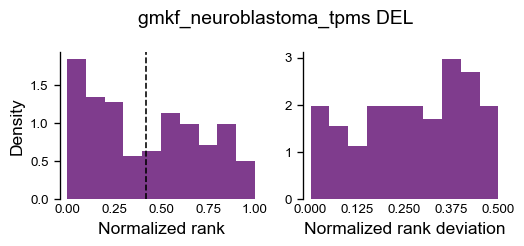

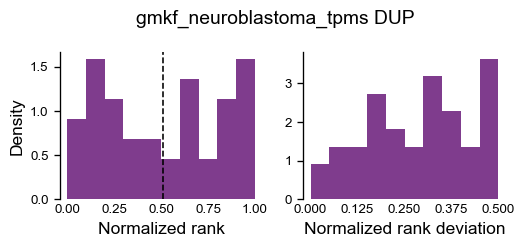

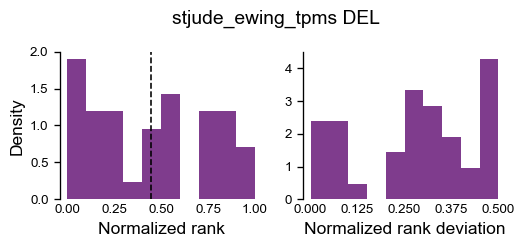

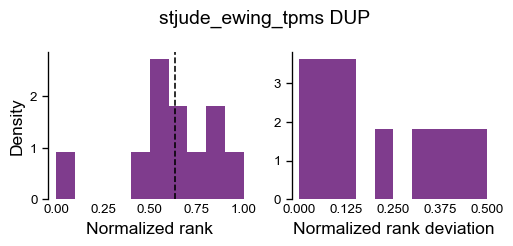

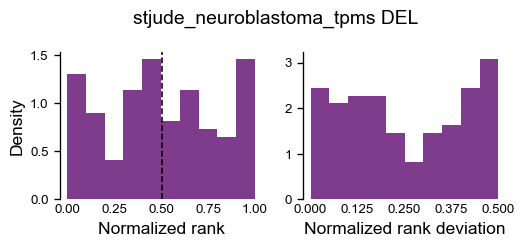

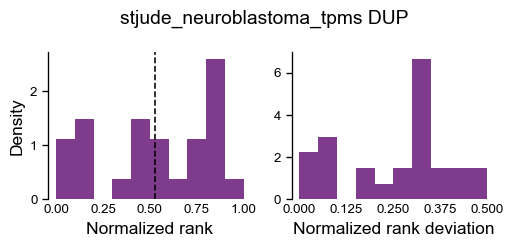

In [35]:
for cohort in ['gmkf_neuroblastoma_tpms', 'stjude_ewing_tpms', 'stjude_neuroblastoma_tpms']:
    for svtype in ['DEL', 'DUP']:

        svtype_subset = coding_ss_sg_svs.query(f'cohort == "{cohort}" & svtype == "{svtype}"')

        num_genes = len(svtype_subset)
        rank_deviation = np.abs(0.5 - svtype_subset['mean_greater_0_dosage_rank'])
        ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
        p = 1 - ref_dist.cdf(rank_deviation.mean())

        print(cohort, svtype, rank_deviation.mean(), p)

        fig, axes = plt.subplots(1, 2, figsize = (6, 2))
        fig.suptitle(f'{cohort} {svtype}', y = 1.1)
        axes[0].hist(svtype_subset['mean_greater_0_dosage_rank'], 
                     bins = np.arange(0, 1.1, 0.1), density = True)
        axes[0].axvline(x = svtype_subset['mean_greater_0_dosage_rank'].mean(), linestyle = 'dashed', color = 'black')
        axes[1].hist(rank_deviation, bins = np.arange(0, 0.55, 0.05),
                     density = True)

        for ax in axes:
            sns.despine(ax = ax, bottom = True)
            ax.tick_params(axis = 'x', length = 0)

        axes[0].set_xlim([-0.04, 1.04])
        axes[1].set_xlim([-0.02, 0.52])
        axes[1].set_xticks([0, 0.125, 0.25, 0.375, 0.5])

        axes[0].set_xlabel('Normalized rank')
        axes[1].set_xlabel('Normalized rank deviation')
        axes[0].set_ylabel('Density')


Nope, that's not it. Is it that these data actually represent a fraction of the total overall samples? Like for some reason, this is just reflecting the influence of some weird samples?

In [36]:
samples = []
for cohort in ['gmkf_neuroblastoma_tpms', 'stjude_ewing_tpms', 'stjude_neuroblastoma_tpms']:
    
    temp = coding_ss_sg_svs[coding_ss_sg_svs['cohort'] == cohort]
    
    coding_sv_names = temp['name'].tolist()
    coding_sv_dosages = dosage_dict[cohort].loc[coding_sv_names]

    for index, row in coding_sv_dosages.iterrows():
        s = row[row > 0]
        assert len(s) == 1

        samples.append([cohort, s.index[0]])

sample_counts = pd.DataFrame(samples, columns = ['cohort', 'sample'])
sample_counts = sample_counts.groupby(['cohort', 'sample']).size().reset_index().rename(columns = {0: 'count'})
sample_counts.sort_values(by = ['cohort', 'count'], ascending = False).head()


,cohort,sample,count
95,stjude_neuroblastoma_tpms,SJ012407,8
99,stjude_neuroblastoma_tpms,SJ030203,7
114,stjude_neuroblastoma_tpms,SJ030917,7
115,stjude_neuroblastoma_tpms,SJ030925,7
108,stjude_neuroblastoma_tpms,SJ030793,6


In [37]:
sample_counts.groupby('cohort').apply(lambda g: len(set(g['sample'])))

cohort
gmkf_neuroblastoma_tpms      75
stjude_ewing_tpms            17
stjude_neuroblastoma_tpms    47
dtype: int64

So 75 out of 89 samples are represented here, which isn't bad. But that doesn't tell us if a subset of samples are actually driving the signal or not. Need to do a bit more work to figure that out.

In [60]:
coding_ss_sg_svs['rank_deviation'] = np.abs(0.5 - coding_ss_sg_svs['mean_greater_0_dosage_rank'])
coding_ss_sg_svs['sample_affected'] = pd.DataFrame(samples)[1].tolist()

In [64]:
# how many samples have at least one SV in the top or bottom 10% by rank?
coding_ss_sg_svs['extreme_rank'] = coding_ss_sg_svs['rank_deviation'] > 0.40
num_extreme = coding_ss_sg_svs[coding_ss_sg_svs['extreme_rank']]# .groupby(['cohort', 'sample_affected']).size()
num_extreme.groupby('cohort').apply(lambda g: len(set(g['sample_affected'])))

cohort
gmkf_neuroblastoma_tpms      35
stjude_ewing_tpms            12
stjude_neuroblastoma_tpms    29
dtype: int64

So 34 out of 75 of those samples have expression in an extreme rank, which I think is a good sign. Can we just check that if we subsample to individual samples, we get similar results?

In [65]:
# p_vals = []
# for i in range(10000):
#     temp = coding_ss_sg_svs.sample(frac=1, replace = False)
#     temp = temp.drop_duplicates(subset = ['sample_affected'])
    
#     ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * len(temp))))
#     p = 1 - ref_dist.cdf(temp['rank_deviation'].mean())
#     p_vals.append(p)

In [66]:
# (np.array(p_vals) < 0.05).mean()

Interesting. Only 38% of the time, this subselection process results in a significant result. What if we drop samples that have more than 4 counts?

In [67]:
# for cutoff in [4, 3, 2, 1]:
#     fewer_than = sample_counts[sample_counts['count'] <= cutoff]['sample'].tolist()
#     subset = coding_ss_sg_svs[coding_ss_sg_svs['sample_affected'].isin(fewer_than)]
    
#     ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * len(subset))))
#     p = 1 - ref_dist.cdf(subset['rank_deviation'].mean())
    
#     print(subset['mean_greater_0_dosage_rank'].mean(), subset['rank_deviation'].mean(), p)

Still significant, and it remains borderline significant even as you drop it more. So I don't think individual samples are influencing things all that much. Interesting!

## Examine other coding contexts

I want to examine other coding contexts:

- Common SVs (those that affect many samples)
- CNVs

In [68]:
# for sv_effect in ['coding', 'non-coding']:
#     results = sv_rna_results.query(f'sv_effect == "{sv_effect}"')
    
#     # select SVs with a good mix of samples with the SV and those without
#     high_af_svs = results[(results['num_samples_nonzero'] >= 4) &
#                           (results['num_samples_genotyped'] - results['num_samples_nonzero'] >= 4)].copy()
    
#     high_af_svs = high_af_svs[(high_af_svs[f'sv_{sv_effect}_counts'] == 1)]
#     print(high_af_svs.shape[0], end = ', ')
    
#     high_af_svs['log2FC'] = np.log2(high_af_svs['mean_greater_0_exp'] / high_af_svs['mean_leq_0_exp'])
#     high_af_svs['-logp'] = -np.log10(high_af_svs['ordinal_p'])
#     print((high_af_svs['log2FC'] > 0).mean())
    
#     fig, ax = plt.subplots(1, figsize = (4, 3))
#     sns.scatterplot(x = 'log2FC', y = '-logp', data = high_af_svs, ec = None, s = 4)
#     sns.despine()
#     ax.set_xlabel('log2-FC (mut vs. WT)')
#     ax.axhline(y = -np.log10(0.05 / len(high_af_svs)), linestyle = 'dashed', color = 'black', label = 'Bonferroni')
#     ax.legend(bbox_to_anchor = (1, 0.5))
    
#     # fig.savefig('images/high-af-coding-SV-expression-effect.png', bbox_inches = 'tight')

In [69]:
# (high_af_svs['log2FC'] < 0).mean()

# Examine our categories

We start by importing our category data

In [70]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_...,ewing,noncoding


In [71]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

In [72]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category
0,0.175033,0.771178,0.226968,0.820448,2,1,644,646,12,1,4687,4699,20,DEL.SINGLETON.ANY.missense_constrained.ANY.sig...,DEL,SINGLETON,0.003096,0.002554,0.002619,0.085949,neuroblastoma,coding,singleton
1,0.245302,0.150614,1.628679,0.103381,53,1,593,646,309,2,4403,4699,479,DEL.SINGLETON.ANY.unconstrained.expressed_in_a...,DEL,SINGLETON,0.082043,0.065759,0.067727,0.985559,neuroblastoma,coding,singleton


In [73]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

## Crunch these categories

We'll replicate an example we've done previously

In [74]:
significant_categories = framework_results.query('negative_log10_p_value > 3.5')
significant_categories.groupby(['sv_category', 'disease']).size()


sv_category  disease      
coding       ewing             8
             neuroblastoma    10
noncoding    neuroblastoma    71
dtype: int64

In [75]:
significant_categories.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category
2,0.332482,0.089278,3.724134,1.959872e-04,148,3,513,646,800,3,3982,4699,1259,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,DEL,SINGLETON,0.229102,0.170249,0.177362,3.707772,neuroblastoma,coding,singleton
13,0.275982,0.054006,5.110167,3.218741e-07,393,5,356,646,2172,4,3011,4699,3436,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,DEL,SINGLETON,0.608359,0.462226,0.479888,6.492314,neuroblastoma,coding,singleton


In [76]:
p_vals = []
for index, row in significant_categories.iterrows():
    cat = row['category_name']
    sv_effect = row['sv_category']
    disease = row['disease']
    
    svs_in_category = category_svs[(category_svs['category'] == cat) &
                                   (category_svs['disease'] == disease) &
                                   (category_svs['sv_category'] == sv_effect)]['SV'].tolist()
    
    cohorts = ['gmkf_neuroblastoma_tpms', 'stjude_neuroblastoma_tpms'] if disease == 'neuroblastoma' else ['stjude_ewing_tpms']
    
    for c in cohorts:

        category_rna_results = sv_rna_results[(sv_rna_results['cohort'] == c) &
                                              (sv_rna_results['name'].isin(svs_in_category))]
    
    
        category_rna_results = category_rna_results[(category_rna_results[f'sv_{sv_effect}_counts'] == 1) & 
                                                    (category_rna_results['sv_effect'] == sv_effect)]

        try:
            rank_deviation = np.mean(np.abs(0.5 - category_rna_results['mean_greater_0_dosage_rank']))

            num_genes = len(category_rna_results)
            ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
            p_mean = 1 - ref_dist.cdf(rank_deviation)
            rank_mean = np.mean(category_rna_results['mean_greater_0_dosage_rank'])

        except:
            p_mean = np.nan
            rank_mean = np.nan

        p_vals.append([c, cat, sv_effect, p_mean, rank_mean])
    
p_vals = pd.DataFrame(p_vals, columns = ['cohort', 'category_name', 'sv_effect', 'p_mean', 'rank_mean'])

In [82]:
neuroblastoma_results = p_vals[(p_vals['cohort'].str.contains('neuroblastoma')) & (p_vals['category_name'].str.contains('SINGLETON'))]
gmkf = neuroblastoma_results.query('cohort == "gmkf_neuroblastoma_tpms"').drop(columns = 'cohort')
stjude = neuroblastoma_results.query('cohort == "stjude_neuroblastoma_tpms"').drop(columns = 'cohort')

merged_nbl = gmkf.merge(stjude, on = ['category_name', 'sv_effect'], suffixes = ['_gmkf', '_stjude'])

In [84]:
merged_nbl.query('p_mean_gmkf < 0.05 | p_mean_stjude < 0.05')

,category_name,sv_effect,p_mean_gmkf,rank_mean_gmkf,p_mean_stjude,rank_mean_stjude
0,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,0.023344,0.337599,0.677413,0.400424
1,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,0.001779,0.367320,0.780971,0.427265
2,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,0.041361,0.380590,0.886577,0.418785
3,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,0.002267,0.369622,0.950155,0.401002
4,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,0.001927,0.391780,0.878000,0.422160
5,ANY.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,0.027843,0.354664,0.886577,0.418785
6,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gla...,coding,0.000421,0.378383,0.893574,0.374647
7,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,coding,0.000375,0.371611,0.749211,0.427941
8,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,0.023344,0.337599,0.677413,0.400424
9,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,0.001779,0.367320,0.780971,0.427265


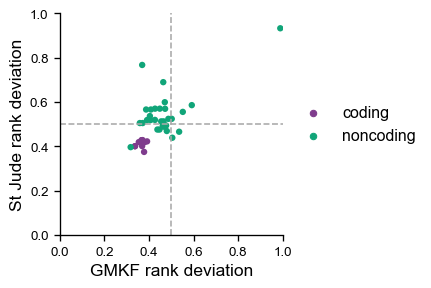

In [85]:
fig, ax = plt.subplots(1, figsize = (3, 3))
sns.scatterplot(data = merged_nbl, x= 'rank_mean_gmkf', y = 'rank_mean_stjude', ec = None, hue = 'sv_effect')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend(bbox_to_anchor = (1, 0.5))
ax.axvline(x = 0.5, color = 'darkgrey', linestyle = 'dashed')
ax.axhline(y = 0.5, color = 'darkgrey', linestyle = 'dashed')
ax.set_xlabel('GMKF rank deviation')
ax.set_ylabel('St Jude rank deviation')
sns.despine(ax = ax)

In [86]:
significant_categories_results = significant_categories.merge(p_vals, on = 'category_name')
significant_categories_results['-log10(cat_p)'] = -np.log10(significant_categories_results['p_value'])
significant_categories_results['-log10(p_mean)'] = -np.log10(significant_categories_results['p_mean'])

In [89]:
p_vals

,cohort,category_name,sv_effect,p_mean,rank_mean
0,gmkf_neuroblastoma_tpms,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,0.023344,0.337599
1,stjude_neuroblastoma_tpms,DEL.SINGLETON.ANY.unconstrained.ANY.protein_co...,coding,0.677413,0.400424
2,gmkf_neuroblastoma_tpms,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,0.001779,0.367320
3,stjude_neuroblastoma_tpms,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,0.780971,0.427265
4,gmkf_neuroblastoma_tpms,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTI...,coding,0.041361,0.380590
...,...,...,...,...,...
165,stjude_neuroblastoma_tpms,ANY.RARE.PREDICTED_NONCODING_SPAN.neuroblastom...,noncoding,0.239234,0.346927
166,gmkf_neuroblastoma_tpms,ANY.RARE.PREDICTED_NONCODING_SPAN.recombinatio...,noncoding,0.792045,0.367424
167,stjude_neuroblastoma_tpms,ANY.RARE.PREDICTED_NONCODING_SPAN.recombinatio...,noncoding,0.288498,0.169492
168,gmkf_neuroblastoma_tpms,ANY.RARE.ANY.neuroblastoma_ABC_MAX_enhancer.PR...,noncoding,0.707280,0.575758


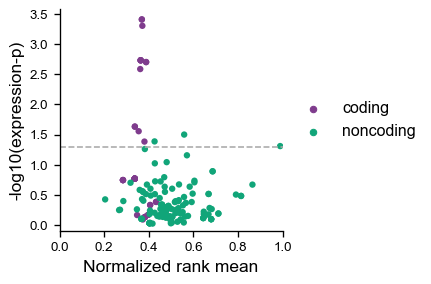

In [53]:
fig, ax = plt.subplots(1, figsize = (3, 3))
sns.scatterplot(x = 'rank_mean', y = '-log10(p_mean)', data = significant_categories_results, hue = 'sv_category', ec = None)
ax.set_xlabel('Normalized rank mean')
ax.set_ylabel('-log10(expression-p)')
sns.despine(ax = ax)
ax.set_xlim([-0.1, None])
ax.set_ylim([-0.1, None])
ax.axhline(y = -np.log10(0.05), linestyle = 'dashed', color = 'darkgrey')
ax.legend(bbox_to_anchor = (1, 0.5))
ax.set_xlim([0, 1])
fig.savefig('images/cwas-categories-expression-significance.png', bbox_inches = 'tight')

In [54]:
example_category = 'DEL.SINGLETON.ANY.ANY.ANY.protein_coding'
svs_in_category = nbl_category_svs[nbl_category_svs['category'] == example_category]['SV'].tolist()
category_rna_results = sv_rna_results[sv_rna_results['name'].isin(svs_in_category)]
category_rna_results = category_rna_results[(category_rna_results[f'sv_coding_counts'] == 1) & 
                                            (category_rna_results['sv_effect'] == "coding")]

print(coding_ss_sg_svs['mean_greater_0_dosage_rank'].mean(), category_rna_results['mean_greater_0_dosage_rank'].mean())
print(stats.mannwhitneyu(coding_ss_sg_svs['mean_greater_0_dosage_rank'], category_rna_results['mean_greater_0_dosage_rank']))

indices = np.random.choice(range(len(coding_ss_sg_svs)), size = (37, 1000000))
iteration_means = coding_ss_sg_svs['mean_greater_0_dosage_rank'].values[indices].mean(axis = 0)
print((iteration_means < category_rna_results['mean_greater_0_dosage_rank'].mean()).mean())

NameError: name 'nbl_category_svs' is not defined

## Make heatmaps

In [44]:
def make_heatmap(category_rna_results):
    
    genes = category_rna_results['gene'].tolist()
    heatmap_exp = analysis_tpms.loc[genes]
    heatmap_cols = analysis_tpms.columns

    heatmap_exp_values = heatmap_exp.values

    # we now need to scramble the rows by sorting by expression
    ordered_indices = np.argsort(heatmap_exp_values, axis = 1)
    heatmap_exp_values = np.sort(heatmap_exp_values, axis = 1)

    # create a mask for 0 expression
    mask = (heatmap_exp_values == 0)
    masked_data = np.where(mask, heatmap_exp_values, np.nan)

    # convert heatmap data to zscore
    heatmap_exp_values = stats.zscore(heatmap_exp_values, axis = 1)
    
    fig = plt.figure(figsize=(10, 0.25 * heatmap_exp_values.shape[0]))
    gs = fig.add_gridspec(1)
    
    # plot the heatmap
    heatmap_ax = fig.add_subplot(gs[0])
    
    sns.heatmap(heatmap_exp_values, cmap="coolwarm", robust=True, 
                ax = heatmap_ax, cbar_kws={"orientation": "horizontal", "pad":0.02, 'shrink': 0.2})
    
    # label the colorbar
    cbar = heatmap_ax.collections[0].colorbar
    cbar.set_label('expression z-score')
    
    # apply a mask for 0 expression
    sns.heatmap(masked_data, cmap=['darkgrey'], annot=False, cbar=False, mask=~mask, 
                ax = heatmap_ax, label = '0 expression')

    heatmap_ax.set_yticks(np.arange(len(genes)) + 0.5)
    heatmap_ax.set_yticklabels(genes, rotation = 0, ha = 'right', fontstyle = 'italic');
    aesthetics.strip_axis(ax = heatmap_ax, y = 'label')
    heatmap_ax.tick_params(axis = 'y', length = 0)
    
    # label the samples with SVs
    label = True
    for i, row in category_rna_results.iterrows():
        sv = row['name']
        dosages = analysis_dosages.loc[sv]
        samples_with_sv = list(dosages[dosages > 0].index)

        for s in samples_with_sv:
            sorted_s = heatmap_cols[ordered_indices[i, :]]
            s_idx = list(sorted_s).index(s)
            label_s = 'sample with SV' if label else ''
            heatmap_ax.scatter(x = s_idx + 0.5, y = i + 0.5, color = 'black', s = 10, label = label_s)
            label = False
            
    heatmap_ax.legend(bbox_to_anchor = (0.75, -0.10))
    heatmap_ax.set_title(category, fontsize = 9)
    
    return fig

In [45]:
for index, row in significant_categories_results.iterrows():
    category = row['category_name']
    sv_effect = row['sv_category']
    p_mean = row['p_mean']
    
    path = f'data/cwas-results/expression-plots/{category}'
    if not os.path.isdir(path):
        os.mkdir(path)
        
    
    svs_in_category = nbl_category_svs[nbl_category_svs['category'] == category]['SV'].tolist()
    category_rna_results = sv_rna_results[(sv_rna_results['name'].isin(svs_in_category)) &
                                          (sv_rna_results['sv_effect'] == f'{sv_effect}')].sort_values(by = 'mean_greater_0_dosage_rank').reset_index(drop = True)
    if len(category_rna_results) == 0:
        continue

    # make and save the heatmap
    heatmap_fig = make_heatmap(category_rna_results)
    heatmap_fig.savefig(path + '/expression-heatmap.png', bbox_inches = 'tight')
    plt.close(heatmap_fig)
    
    # get the distribution of ranks
    rank_fig, axes = plt.subplots(2, 1, figsize = (4, 4), gridspec_kw = {'hspace': 0.5})

    for i, analysis in enumerate(['abs', 'dev']):
        if analysis == 'dev':
            data = np.abs(0.5 - category_rna_results['mean_greater_0_dosage_rank'])
            bins = np.arange(0, 0.55, 0.05)
            xlim = [-0.025, 0.50]
        else:
            data = category_rna_results['mean_greater_0_dosage_rank']
            bins = np.arange(0, 1.1, 0.1)
            xlim = [-0.05, 1.0]

        axes[i].hist(data, bins)
        label = '% expression rank of samples with SV' if analysis == 'abs' else 'rank deviation'  

        axes[i].set_xlabel(label)
        axes[i].set_ylabel('SV count')
        axes[i].set_xlim(xlim)
        aesthetics.strip_axis(ax = axes[i], x = 'label', y = 'ignore')

    p_label = "p_mean = {:.2g}".format(p_mean)
    axes[0].text(x = 0.5, y = 0.75, s = p_label, transform = axes[0].transAxes, fontsize = 10, ha = 'center')
    axes[0].set_title(category, fontsize = 8)

    rank_fig.savefig(path + '/expression-histogram.png', bbox_inches = 'tight')
    plt.close(rank_fig)

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


# Examine adipogenesis

Alright, the last damn thing. I want to know if this stupid gene set is upregulated at all. We'll compare samples with an SV in the category vs. those that don't have one/

In [51]:
gene_sets = {}
with open('ref/gene-sets.txt') as gs_in:
    for line in gs_in:
        comp = line.strip().split('\t')
        db = comp[0]
        gs = comp[1]
        genes = comp[2:]
        gene_sets[db + ' | ' + gs] = genes

In [76]:
adipogenesis_genes = set(gene_sets['MSigDB_Hallmark_2020 | Adipogenesis']) & set(analysis_tpms.index)
len(adipogenesis_genes)

188

In [77]:
coding_cols = ['PREDICTED_LOF', 'PREDICTED_PARTIAL_EXON_DUP', 'PREDICTED_INTRAGENIC_EXON_DUP', 'PREDICTED_COPY_GAIN']
noncoding_cols = ['PREDICTED_NEAREST_TSS', 'PREDICTED_INTRONIC', 'PREDICTED_PROMOTER', 'PREDICTED_UTR']

In [78]:
# determine which rows have a gene of adipogenesis affected
affected_genes = analysis_svs[coding_cols + noncoding_cols].fillna('')

adipo = []
for index, row in affected_genes.iterrows():
    genes_affected = []
    for col in coding_cols + noncoding_cols:
        genes_affected += row[col].split(',')
        
    genes_affected = [g for g in genes_affected if g != '']
    
    if len(set(genes_affected) & set(adipogenesis_genes)):
        adipo.append(True)
    else:
        adipo.append(False)


In [109]:
svs_in_adipo = analysis_svs[adipo]['name'].tolist()
adipo_dosage = analysis_dosages.loc[svs_in_adipo]

# drop SVs present in more than 2 samples
adipo_dosage = adipo_dosage[adipo_dosage.sum(axis = 1) < 2]
adipo_dosage = adipo_dosage.sum(axis = 0)

In [110]:
ss = gp.ssgsea(data=analysis_tpms,
               gene_sets={'Adipogenesis': adipogenesis_genes},
               outdir=None,
               sample_norm_method='rank',
               no_plot=True,
               min_size=4)

signatures = ss.res2d
signatures.columns = ['sample', 'signature', 'enrichment_score', 'normalized_enrichment_score']

In [111]:
signatures = signatures.set_index('sample')
signatures.loc[adipo_dosage.index, 'adipogenesis_dosage'] = adipo_dosage

In [112]:
import scipy.stats

In [113]:
scipy.stats.spearmanr(signatures['normalized_enrichment_score'], signatures['adipogenesis_dosage'])

SpearmanrResult(correlation=-0.04837927494132474, pvalue=0.6525511674102056)

# Riaz's TAD Boundaries

Riaz has taken a look at the TAD boundary categories and "expanded them" to include all genes in the TAD. So effectively, a count for an SV in the TAD boundary leads to a count for all the genes in a TAD.

He's identified a list of these genes and would like to know if the expression within these samples is systematically effected. Let's take a look.

In [173]:
riaz_tads = pd.read_csv('data/CWAS data for Jett/TAD_category_of_interest_SVs_in_cases_tibble_subsetted_with_TAD_boundaries_TADs_and_genes_unique_with_samples_and_study_12_2_23.txt', sep='\t')
riaz_tads.head(2)

,SV_name,TAD_boundary_ID,gene,sample,study
0,PedSV.2.5.2_DEL_chr1_832,TAD_boundary_15,ARHGEF16,PT_HA7TBZ1V,GMKF
1,PedSV.2.5.2_DEL_chr1_832,TAD_boundary_15,MEGF6,PT_HA7TBZ1V,GMKF


In [174]:
riaz_tads.shape

(916, 5)

In [159]:
included_samples = list(analysis_tpms.columns)

In [160]:
len(set(riaz_tads['sample'])), len(set(riaz_tads['sample']) & set(included_samples))

(222, 35)

In [175]:
riaz_tads[riaz_tads['sample'].isin(included_samples)].shape

(105, 5)

In [164]:
subsamples = set(riaz_tads['sample']) & set(included_samples)
subgenes = riaz_tads[riaz_tads['sample'].isin(subsamples)]['gene']
print(len(subgenes), len(set(subgenes) & set(analysis_tpms.index)))

105 89


And only 96 of the genes are in the TPM matrix.

In [165]:
len(subsamples)

35

In [191]:
riaz_tad_rna_results = sv_rna_results[sv_rna_results['name'].isin(riaz_tads['SV_name'].tolist())].sort_values(by = 'mean_greater_0_dosage_rank').reset_index(drop = True)
riaz_tad_rna_results.shape

(40, 22)

In [192]:
riaz_tad_rna_results['mean_greater_0_dosage_rank'].mean()

0.4425809822361547

In [193]:
rank_deviation = np.abs(0.5 - riaz_tad_rna_results['mean_greater_0_dosage_rank'])
mean_dev_rank = np.mean(rank_deviation)
num_genes = riaz_tad_rna_results.shape[0]

print(mean_dev_rank)

0.25435606060606064


In [194]:
# now we do some statistics. A KS test, to start
p_ks = stats.kstest(rank_deviation, lambda x: 2 * x)[1]

# now do the sample mean test
ref_dist = stats.norm(loc = 0.25, scale = np.sqrt(1/(48 * num_genes)))
p_mean = 1 - ref_dist.cdf(mean_dev_rank)

print(p_ks, p_mean)

0.8659352714722139 0.4243125421792442


So nominally, these are not significant.

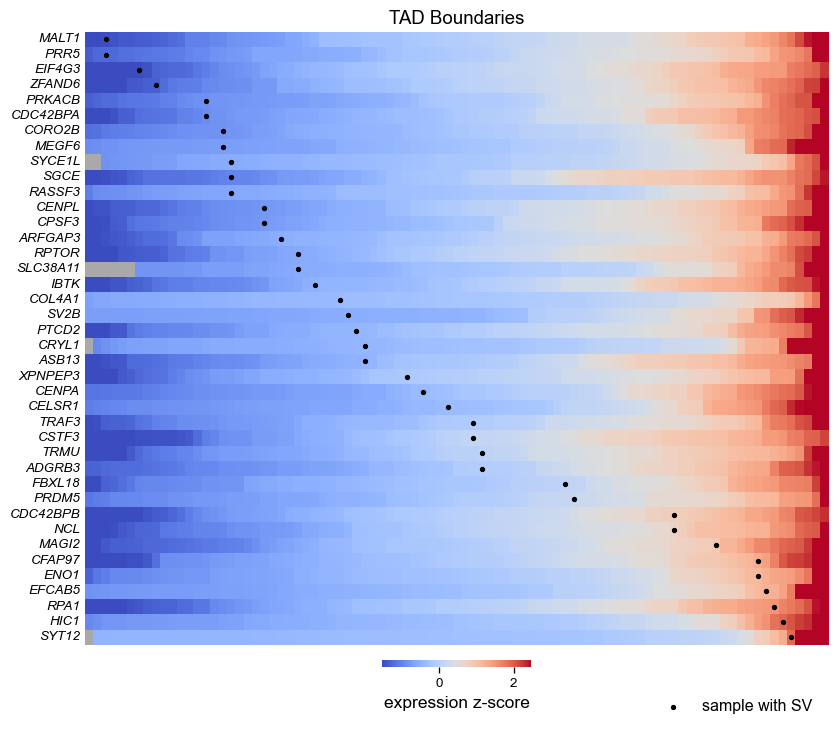

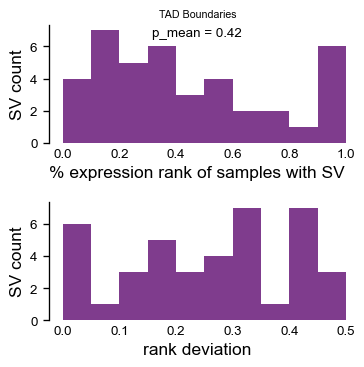

In [202]:
# make and save the heatmap
heatmap_fig = make_heatmap(riaz_tad_rna_results)
heatmap_fig.axes[0].set_title('TAD Boundaries')
heatmap_fig.savefig('data/cwas-results/expression-plots/tad-boundaries/expression-heatmap.png', bbox_inches = 'tight')

# get the distribution of ranks
rank_fig, axes = plt.subplots(2, 1, figsize = (4, 4), gridspec_kw = {'hspace': 0.5})

for i, analysis in enumerate(['abs', 'dev']):
    if analysis == 'dev':
        data = np.abs(0.5 - riaz_tad_rna_results['mean_greater_0_dosage_rank'])
        bins = np.arange(0, 0.55, 0.05)
        xlim = [-0.025, 0.50]
    else:
        data = riaz_tad_rna_results['mean_greater_0_dosage_rank']
        bins = np.arange(0, 1.1, 0.1)
        xlim = [-0.05, 1.0]

    axes[i].hist(data, bins)
    label = '% expression rank of samples with SV' if analysis == 'abs' else 'rank deviation'  

    axes[i].set_xlabel(label)
    axes[i].set_ylabel('SV count')
    axes[i].set_xlim(xlim)
    aesthetics.strip_axis(ax = axes[i], x = 'label', y = 'ignore')

p_label = "p_mean = {:.2g}".format(p_mean)
axes[0].text(x = 0.5, y = 0.90, s = p_label, transform = axes[0].transAxes, fontsize = 10, ha = 'center')
axes[0].set_title('TAD Boundaries', fontsize = 8)

rank_fig.savefig('data/cwas-results/expression-plots/tad-boundaries/expression-histogram.png', bbox_inches = 'tight')

In [197]:
heatmap_fig.axes[0]

<AxesSubplot:title={'center':'DEL.RARE.ANY.recombination_hotspot_conserved.ANY.lof_constrained.ANY.cosmic_and_germline_CPGs'}>